<a href="https://colab.research.google.com/github/davidtweedle/elliptic-curve-data-science/blob/main/cond_100k_rescaled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Revisiting curves with conductor approximately 100000
---------------------------------------------------------
We revisit the data constructed from elliptic curves with conductor in the range $100002$ to $100800$.
By using our function
```bin_murmuration```
on this data, the main effect is to smooth out the curve somewhat.

In [1]:
import os
using_colab = 'COLAB_GPU' in os.environ

In [2]:
if using_colab:
  !pip install -q ipympl
  from google.colab import output
  output.enable_custom_widget_manager()

In [3]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import subplots
%matplotlib widget

In [4]:
if using_colab:
  def display_murmuration(ec,scale,primes,title,ax,xlim=None,ylim=None):
    for axis in ax:
      axis.clear();
      if xlim:
        axis.set_xlim(*xlim)
      if ylim:
        axis.set_ylim(*ylim)
    t = primes.astype(int)*scale;
    ax[0].plot(t,ec.loc[ec['rank']==1,primes].mean(),'b.');
    ax[1].plot(t,ec.loc[ec['rank']==-1,primes].mean(),'r.');
    ax[2].plot(t,ec[primes].mul(ec['rank'],axis=0).mean(),'c.');
    ax[0].set_title(title+", even rank");
    ax[1].set_title(title+", odd rank");
    ax[2].set_title(title+", combined ranks");

  def bin_murmuration(ec:pd.DataFrame, primes:pd.Index, x):
    n = len(x)
    idx = np.digitize(np.outer(np.reciprocal(1.0*ec['conductor']),primes.astype(float)),x)
    counts = np.zeros(shape=x.shape)
    sum_aps = np.zeros(shape=x.shape)
    for i in range(n):
      where = np.equal(idx,i)
      counts[i] = where.sum()
      sum_aps[i] = ec[primes].to_numpy()[where].sum()
    return sum_aps,counts

  def display_rescaled_murmuration(x,sum_aps_even,counts_even,sum_aps_odd,counts_odd,title,ax,xlim=None,ylim=None):
    for axis in ax:
      axis.clear();
      if xlim:
        axis.set_xlim(*xlim)
      if ylim:
        axis.set_ylim(*ylim)
    ax[0].plot(x,sum_aps_even/counts_even,'b.');
    ax[1].plot(x,sum_aps_odd/counts_odd,'r.');
    ax[2].plot(x,(sum_aps_even-sum_aps_odd)/(counts_even+counts_odd),'c.');
    ax[0].set_title(title+", even");
    ax[1].set_title(title+", odd");
    ax[2].set_title(title+", combined ranks");
else:
  from pyscript.murmur_from_dataframe import display_murmuration, display_rescaled_murmuration, bin_murmuration


In [5]:
from google.colab import auth
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')
import io
from googleapiclient.http import MediaIoBaseDownload

fileIds = {"cond_200k_1.data": "1-vdzWqg7RgjXvtsMAAW7MWsMt5tFjnTS"
}

def load_file(file_name, index_col, using_colab=True):
  file_link = None
  if using_colab:
    request = drive_service.files().get_media(fileId=fileIds[file_name])
    file_link = io.BytesIO()
    downloader = MediaIoBaseDownload(file_link, request)
    done = False
    while done is False:
      _, done = downloader.next_chunk()
    file_link.seek(0)
  else:
    file_link="data/" + file_name
  datatype = {index_col: np.dtype('str'),'discriminant':np.dtype('O')}
  datatype.setdefault(np.dtype('int64'))
  res = pd.read_csv(file_link,
                    delimiter=" ",
                    index_col=index_col,
                    usecols=lambda x: x!='discriminant',
                    dtype=datatype
  )
  if using_colab:
    file_link.close()
  return res


In [6]:
ec = load_file(file_name="cond_200k_1.data", using_colab=using_colab, index_col="label")
ec.tail()

,conductor,rank,2,3,5,7,11,13,17,19,...,199873,199877,199889,199909,199921,199931,199933,199961,199967,199999
label,,,,,,,,,,,,,,,,,,,,,
100800.oz1,100800,1,0,0,0,1,4,-2,-2,4,...,654,334,-170,230,450,-356,-434,826,-660,284
100800.oz2,100800,1,0,0,0,1,4,-2,-2,4,...,654,334,-170,230,450,-356,-434,826,-660,284
100800.oz3,100800,1,0,0,0,1,4,-2,-2,4,...,654,334,-170,230,450,-356,-434,826,-660,284
100800.oz4,100800,1,0,0,0,1,4,-2,-2,4,...,654,334,-170,230,450,-356,-434,826,-660,284
100800.pa1,100800,1,0,0,0,1,4,-2,2,-4,...,-114,-582,-642,-46,-526,68,398,-146,-592,376


In [7]:
primes = ec.columns[2:];

In [8]:
N,n = 2,1000;
x = np.linspace(1.0/n,N,n);
sum_aps_even,counts_even = bin_murmuration(ec[ec['rank']%2==0], primes,x);
sum_aps_odd,counts_odd = bin_murmuration(ec[ec['rank']%2==1],primes,x);

In [9]:
scale = 1.0/100000;
ec.loc[ec['rank']%2==1,'rank']=-1;
ec.loc[ec['rank']%2==0,'rank'] =1;

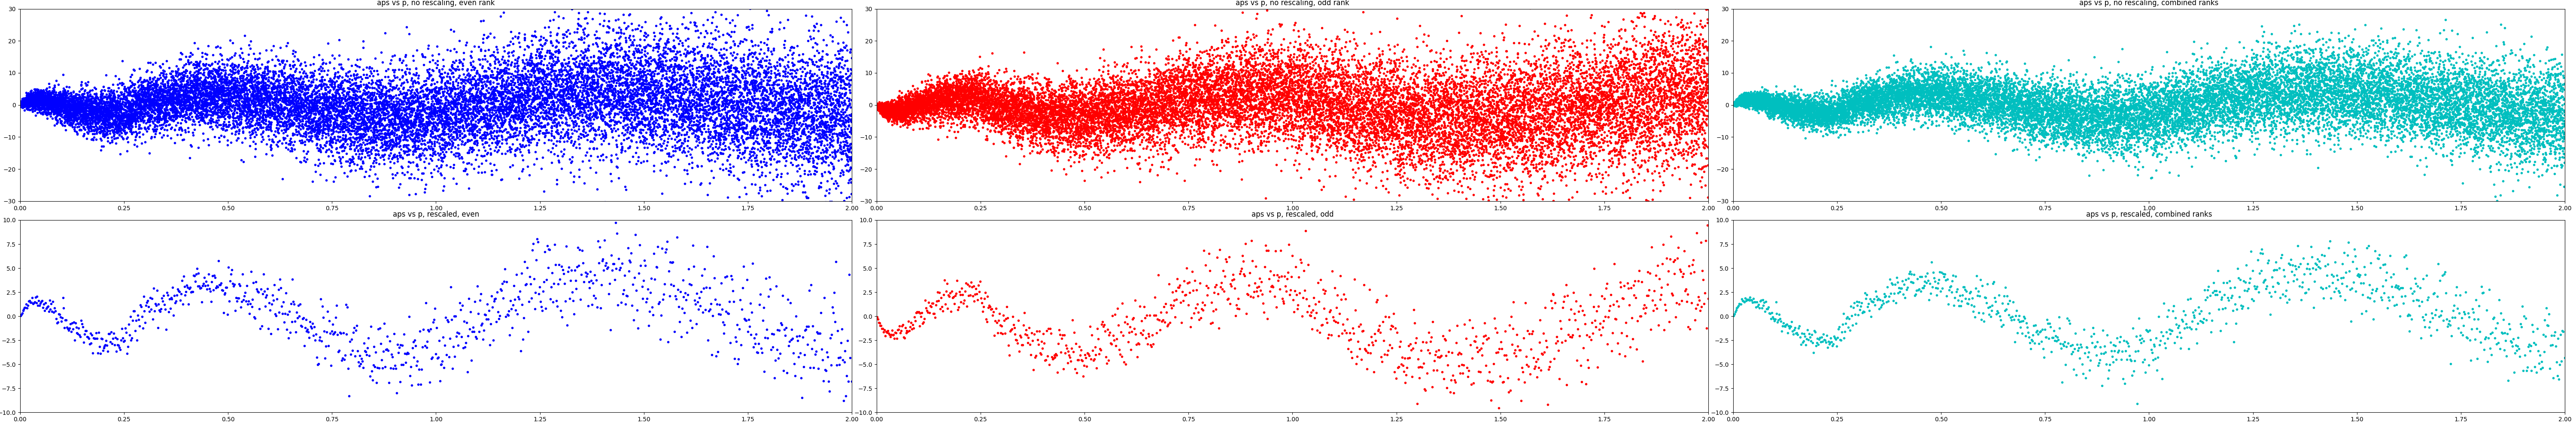

In [10]:
fig, ax = subplots(nrows=2,ncols=3,figsize=(60,10));
fig.tight_layout()
ylims = [(-30,30),(-10,10)]
xlim = (0,2)
display_murmuration(ec,scale,primes,"aps vs p, no rescaling",ax[0],xlim,ylims[0])
display_rescaled_murmuration(x,sum_aps_even,counts_even,sum_aps_odd,counts_odd,"aps vs p, rescaled",ax[1],xlim,ylims[1])

In [11]:
## fig.savefig("media/scaling_vs_no_cond_100k.png")

We are able to see a few of the features that we have seen in the conductor range 1 to 50000.